In [10]:
%matplotlib widget
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import morph_geom_lib as mgl
import models.shallow_depth_morph_models_org as sdmodels
import schemes.avalanche_scheme 


from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
%matplotlib inline
#plt.style.use(['dark_background'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load up the Bed Profile

dx: 0.6505421184320267 cm
nx 1200


Text(0, 0.5, 'z (m)')

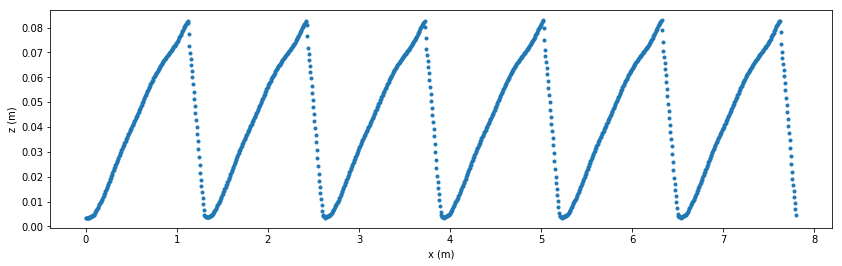

In [11]:
filepath = 'dune_profile_dune5_repeated.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1200)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

# Model Runs for Paper

- Equilibrium vs non-Equlibrium
- Shallow water vs simple flow model
- modified Ycr (+20%, -20%)
- other models (Euler, Upwinding, MacCormick)

In [12]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.0012
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.002

#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 300*60       # Runtime in seconds
dt = 5                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*5

## 20 cm Case Non-Equilibrium

2020-01-25 17:39:22,980 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 17:39:59,908 INFO CLAW: Solution 1 computed for time t=300.000000
0.23701594940081439
0.42807568713511196


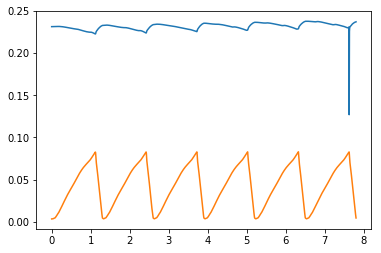

<Figure size 1008x432 with 0 Axes>

In [13]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=2000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut20, q20cm)
model.set_inital_conditions(sOut20, 0.0)
model.set_controller(tfinal = 300, num_output_times=1)
model.run()

h = model.get_hf()
surf = h + z0

plt.plot(x0, surf)
plt.plot(x0, z0)

fig = plt.figure(figsize=(14, 6))
print(surf[len(x0)-1])
print(model.get_uf().mean())

 Starting simulation....
Number of time steps: 60.0 mins
Grid dx = 0.0065054211843202665
Grid nx = 1200
Initializing hydrodynamic model...
2020-01-25 17:40:00,164 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 17:40:29,992 INFO CLAW: Solution 1 computed for time t=241.965501
Completed the intialization of the model
D50:    0.0012
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Max qbedload = 0.0005446698774883707
2020-01-25 17:40:30,044 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 17:40:30,354 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 17:40:32,051 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 17:40:33,001 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 17:40:33,054 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 17:40:33,998 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 17:40:34,116 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 17:40:35,057 INFO CLAW:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2020-01-25 18:47:23,985 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 18:47:24,037 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 18:47:24,974 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 18:47:25,031 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 18:47:25,971 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 18:47:26,023 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 18:47:26,963 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 18:47:27,020 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 18:47:27,960 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 18:47:28,011 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 18:47:28,948 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 18:47:29,003 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 18:47:29,944 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 18:47:2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2020-01-25 19:32:24,051 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 19:32:25,002 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 19:32:25,055 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 19:32:26,007 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 19:32:26,064 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 19:32:27,017 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 19:32:27,068 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 19:32:28,017 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 19:32:28,073 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 19:32:29,030 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 19:32:29,083 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 19:32:30,036 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 19:32:30,093 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 19:32:31

Text(0, 0.5, 'z (m)')

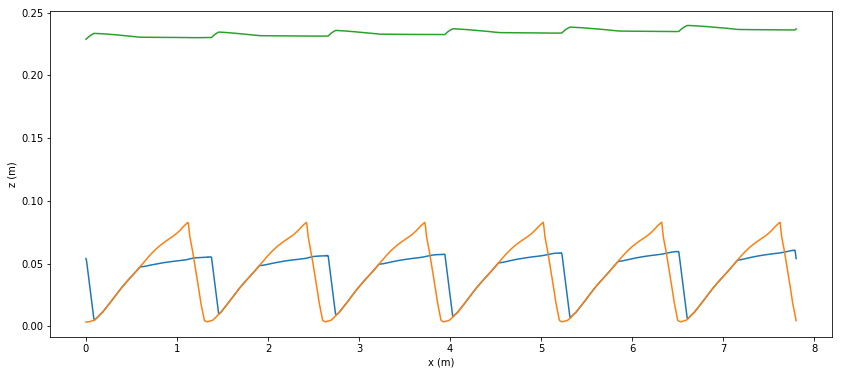

In [14]:


run_name = 'dune_5_q_{0}_h_{1}_D50_{2}'.format('20cm','237mm','1.2mm')

model = sdmodels.ShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q20cm, sOut20)
model.setup_chezy_hydro_model(ks, bed_slope)


#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h

df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

## 32 cm Flow Case 

2020-01-25 19:57:25,665 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 19:58:02,679 INFO CLAW: Solution 1 computed for time t=300.000000
0.356994186134206
0.5921206651245402


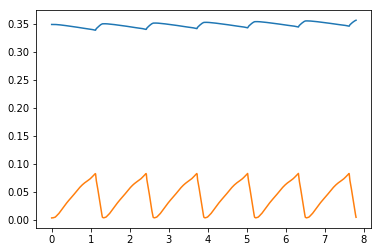

<Figure size 1008x432 with 0 Axes>

In [15]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut32, q32cm)
model.set_inital_conditions(sOut20, 0.0)
model.set_controller(tfinal = 300, num_output_times=1)
model.run()

h = model.get_hf()
surf = h + z0

plt.plot(x0, surf)
plt.plot(x0, z0)

fig = plt.figure(figsize=(14, 6))
print(surf[len(x0)-1])
print(model.get_uf().mean())

 Starting simulation....
Number of time steps: 60.0 mins
Grid dx = 0.0065054211843202665
Grid nx = 1200
Initializing hydrodynamic model...
2020-01-25 19:58:02,946 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 19:58:33,108 INFO CLAW: Solution 1 computed for time t=244.240914
Completed the intialization of the model
D50:    0.0012
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Max qbedload = 8.384325138980628e-06
2020-01-25 19:58:33,161 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 19:58:34,380 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 19:58:34,611 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 19:58:35,845 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 19:58:35,899 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 19:58:37,129 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 19:58:37,235 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 19:58:38,468 INFO CLAW:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2020-01-25 20:57:20,233 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 20:57:20,304 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 20:57:21,560 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 20:57:22,495 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 20:57:23,745 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 20:57:23,816 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 20:57:25,076 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 20:57:26,001 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 20:57:27,253 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 20:57:27,324 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 20:57:28,584 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 20:57:29,481 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-25 20:57:30,732 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-25 20:57:3

Text(0, 0.5, 'z (m)')

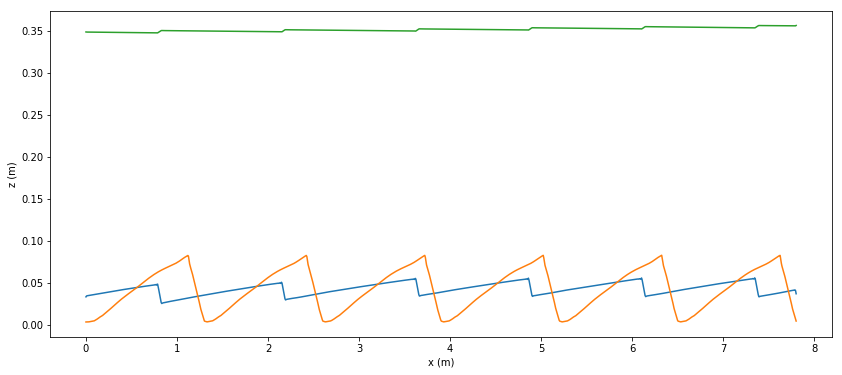

In [16]:
run_name = 'dune_5_q_{0}_h_{1}_D50_{2}'.format('32m','357mm','1.2mm')

model = sdmodels.ShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)


#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h

df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

Text(0.5, 0, 'Time (mins)')

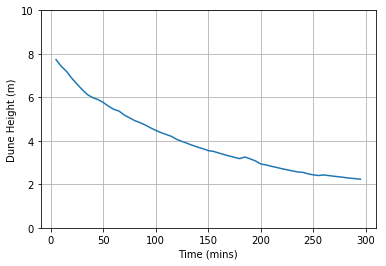

In [18]:
import utils.post_processing as post
verts = np.load('_output/{0}_verts.npy'.format(run_name))

extractionTimeMins = 5.
heights = [post.calculate_wave_height(verts[t,:,1],dx)*100. for t in range((verts.shape[0]))]
times = np.array([(t*extractionTimeMins + 5.0) for t in range((verts.shape[0]))])


#df = pd.read_csv('a3down_dune_heigth.txt',sep='\t')

plt.plot(times,heights)

#plt.plot(df['t'],df['dune'], 'o')

plt.ylim([0,10])
plt.grid()
plt.ylabel('Dune Height (m)')
plt.xlabel('Time (mins)')